In [1]:
## Give appropriate permission to the directory "FOLDER_WITH_ARTIFACTS" you are working with
import os
os.environ['QNN_SDK_ROOT']="/local/mnt/workspace/gokul/QNN/2.19.0.240124" #set up your qnn path here.
os.environ['ANDROID_NDK_ROOT']="/local/mnt/workspace/gokul/android-ndk-r25c"
os.environ['RAW_FILE_FOLDER']="raw"#rawfiles
os.environ['FOLDER_WITH_ARTIFACTS']="YoloX_updated"
os.environ['MODEL_NAME']="yolox_FP32_2_15_1"
os.environ['QUANTIZED_MODEL_NAME']="yolox_a8w8_2_15_1"
os.environ['TARGET_INPUT_LIST']="list.txt"
os.environ['ONDEVICE_FOLDER']="YoloX_updated"
os.environ['DEVICE_HOST']="localhost"
os.environ['DEVICE_ID']="bc468c1d" #fill your device-id. Use command "adb devices" to get devices names. example :"e18d5d0"
os.environ['QNN_TARGET_ARCH']="aarch64-android"
os.environ['QNN_TARGET_STL']="libQnnHtp.so"

In [2]:
import cv2
import glob
import os
import numpy as np
from PIL import Image
import re
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### ONNX Model

In [3]:
!wget https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_x.onnx

### DLC Conversion

- Please create the dlc models(FP32) from the generating_model.ipynb file
- After Creating the Raw file here we'll generate the INT8 Model

# Preprocessing

### Getting the dataset

- Dataset is huge so it'll take time to run this cell

In [4]:
!wget https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels.zip -q --show-progress
!wget http://images.cocodataset.org/zips/val2017.zip -q --show-progress
!unzip val2017.zip
!unzip coco2017labels.zip
!mkdir "raw"

In [5]:
%%bash
rm -rf coco
rm -rf coco2017labels.zip
rm -rf val2017.zip

In [6]:
# dataset is huge to run on device , taking only 15 dataset
files = os.listdir('val2017')
for file in files[15:]:
    os.remove("val2017/"+file)

In [7]:
def preproc(img, input_size, swap=(2, 0, 1)):
    if len(img.shape) == 3:
        padded_img = np.ones((input_size[0], input_size[1], 3), dtype=np.uint8) * 114
    else:
        padded_img = np.ones(input_size, dtype=np.uint8) * 114

    r = min(input_size[0] / img.shape[0], input_size[1] / img.shape[1])
    resized_img = cv2.resize(
        img,
        (int(img.shape[1] * r), int(img.shape[0] * r)),
        interpolation=cv2.INTER_LINEAR,
    ).astype(np.uint8)
    padded_img[: int(img.shape[0] * r), : int(img.shape[1] * r)] = resized_img

    padded_img = padded_img.transpose(swap)
    padded_img = np.ascontiguousarray(padded_img, dtype=np.float32)
    return padded_img, r

### Creating the list file

In [8]:
%%bash
find ./raw -name *.raw > list.txt

#### Creating the INT 8 Model After preparing the raw files

In [9]:
%%bash
source ${QNN_SDK_ROOT}/bin/envsetup.sh
export PATH=${ANDROID_NDK_ROOT}:${PATH}
export TMPDIR=$PWD/temp
${QNN_SDK_ROOT}/bin/x86_64-linux-clang/qnn-onnx-converter --input_network yolox_x.onnx --output_path ${MODEL_NAME}.cpp
${QNN_SDK_ROOT}/bin/x86_64-linux-clang/qnn-model-lib-generator -c ${MODEL_NAME}.cpp -b ${MODEL_NAME}.bin -o model_libs
${QNN_SDK_ROOT}/bin/x86_64-linux-clang/qnn-context-binary-generator \
              --backend ${QNN_SDK_ROOT}/lib/x86_64-linux-clang/libQnnHtp.so \
              --model model_libs/x86_64-linux-clang/lib${MODEL_NAME}.so \
              --binary_file ${MODEL_NAME}.serialized

In [10]:
%%bash
source ${QNN_SDK_ROOT}/bin/envsetup.sh
export PATH=${ANDROID_NDK_ROOT}:${PATH}
export TMPDIR=$PWD/temp
${QNN_SDK_ROOT}/bin/x86_64-linux-clang/qnn-onnx-converter --input_network yolox_x.onnx --output_path ${QUANTIZED_MODEL_NAME}.cpp --input_list list.txt \
                --param_quantizer "adjusted" --act_quantizer "enhanced"
${QNN_SDK_ROOT}/bin/x86_64-linux-clang/qnn-model-lib-generator -c ${QUANTIZED_MODEL_NAME}.cpp -b ${QUANTIZED_MODEL_NAME}.bin -o model_libs2
${QNN_SDK_ROOT}/bin/x86_64-linux-clang/qnn-context-binary-generator \
              --backend ${QNN_SDK_ROOT}/lib/x86_64-linux-clang/libQnnHtp.so \
              --model model_libs2/x86_64-linux-clang/lib${QUANTIZED_MODEL_NAME}.so \
              --binary_file ${QUANTIZED_MODEL_NAME}.serialized

#### Creating Bin and Lib Folder on Device 

In [11]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "mkdir -p /data/local/tmp/qnnexample/$QNN_TARGET_ARCH/bin" && $DEVICE_SHELL shell "mkdir -p /data/local/tmp/qnnexample/$QNN_TARGET_ARCH/lib" && $DEVICE_SHELL shell "mkdir -p /data/local/tmp/qnnexample/dsp/lib"

### Pushing all Lib and Bin files onto Device

In [12]:
%%bash
export ONDEVICE_FOLDER="YoloX_updated"
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "mkdir -p /data/local/tmp/$ONDEVICE_FOLDER"

In [13]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
export ONDEVICE_FOLDER="YoloX_updated"
$DEVICE_SHELL push $QNN_SDK_ROOT/lib/$QNN_TARGET_ARCH/$QNN_TARGET_STL /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $QNN_SDK_ROOT/bin/$QNN_TARGET_ARCH/qnn-net-run /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $QNN_SDK_ROOT/lib/hexagon-v73/unsigned/*.so /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $QNN_SDK_ROOT/lib/$QNN_TARGET_ARCH/*.so /data/local/tmp/$ONDEVICE_FOLDER

/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/aarch64-android/libQnnHtp.so: 1 file pushed, 0 skipped. 409.7 MB/s (1545520 bytes in 0.004s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/bin/aarch64-android/qnn-net-run: 1 file pushed, 0 skipped. 408.5 MB/s (1441208 bytes in 0.003s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/hexagon-v73/unsigned/libCalculator_skel.so: 1 file pushed, 0 skipped. 142.4 MB/s (7128 bytes in 0.000s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/hexagon-v73/unsigned/libQnnHtpV73QemuDriver.so: 1 file pushed, 0 skipped. 497.6 MB/s (7601584 bytes in 0.015s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/hexagon-v73/unsigned/libQnnHtpV73Skel.so: 1 file pushed, 0 skipped. 511.7 MB/s (7360784 bytes in 0.014s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/hexagon-v73/unsigned/libQnnHtpV73.so: 1 file pushed, 0 skipped. 510.6 MB/s (8025008 bytes in 0.015s)
/local/mnt/workspace/gokul/QNN/2.19.0.240124/lib/hexagon-v73/unsigned/libQnnSaver.so: 1 file pushed,

### Pushing Artifacts on to Device

In [14]:
%%bash
export ONDEVICE_FOLDER="YoloX_updated"
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push output/${QUANTIZED_MODEL_NAME}.serialized.bin /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push output/${MODEL_NAME}.serialized.bin /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push model_libs2/aarch64-android/lib${QUANTIZED_MODEL_NAME}.so /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $RAW_FILE_FOLDER /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $TARGET_INPUT_LIST /data/local/tmp/$ONDEVICE_FOLDER

output/yolox_a8w8_2_15_1.serialized.bin: 1 file pushed, 0 skipped. 374.9 MB/s (100549200 bytes in 0.256s)
adb: error: cannot stat 'output/yolox_FP32_2_15_1.serialized.bin': No such file or directory
model_libs2/aarch64-android/libyolox_a8w8_2_15_1.so: 1 file pushed, 0 skipped. 377.8 MB/s (100016744 bytes in 0.252s)
raw/: 14 files pushed, 0 skipped. 465.2 MB/s (68812800 bytes in 0.141s)
list.txt: 1 file pushed, 0 skipped. 6.6 MB/s (322 bytes in 0.000s)


### Inferencing 8 bit DLC on DSP Runtime
* Give name of DLC in OUTPUT_DLC_QUANTIZED8 and ondevice folder

In [15]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell
export ONDEVICE_FOLDER="YoloX_updated"
export device_path=/data/local/tmp/$ONDEVICE_FOLDER
export LD_LIBRARY_PATH=$device_path
export ADSP_LIBRARY_PATH="$device_path"
export PATH=$PATH:$device_path
export QUANTIZED_MODEL_NAME="yolox_a8w8_2_15_1"
cd $device_path
export OUTPUT_FOLDER=OUTPUT_Quant_DSP
cd /data/local/tmp/$ONDEVICE_FOLDER  && 
./qnn-net-run --backend libQnnHtp.so --input_list list.txt --retrieve_context ${QUANTIZED_MODEL_NAME}.serialized.bin --output_dir $OUTPUT_FOLDER

qnn-net-run pid:23447


### Inferencing 32b DLC on CPU Runtime
Give name of DLC in OUTPUT_DLC_32 and ondevice folder

In [16]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell
export ONDEVICE_FOLDER="YoloX_updated"
export device_path=/data/local/tmp/$ONDEVICE_FOLDER
export LD_LIBRARY_PATH=$device_path
export ADSP_LIBRARY_PATH="$device_path"
export PATH=$PATH:$device_path
export QUANTIZED_MODEL_NAME="yolox_a8w8_2_15_1"
cd $device_path
export OUTPUT_FOLDER=OUTPUT_CPU
cd /data/local/tmp/$ONDEVICE_FOLDER  && 
./qnn-net-run --backend libQnnHtp.so --input_list list.txt --model lib${QUANTIZED_MODEL_NAME}.so --output_dir $OUTPUT_FOLDER

qnn-net-run pid:23454


### Pulling Output folder generated on different precision and cores

In [17]:
%%bash
export ONDEVICE_FOLDER="YoloX_updated"
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/OUTPUT_Quant_DSP output/OUTPUT_Quant_DSP
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/OUTPUT_CPU output/OUTPUT_CPU

/data/local/tmp/YoloX_updated/OUTPUT_Quant_DSP/: 14 files pulled, 0 skipped. 130.1 MB/s (39984000 bytes in 0.293s)
/data/local/tmp/YoloX_updated/OUTPUT_CPU/: 14 files pulled, 0 skipped. 95.5 MB/s (39984000 bytes in 0.399s)


# Post Processing


In [18]:
label2class = {'0': 'person', '1': 'bicycle', '2': 'car', '3': 'motorcycle', '4': 'airplane', '5': 'bus', 
               '6': 'train', '7': 'truck', '8': 'boat', '9': 'traffic', '10': 'fire', '11': 'stop', '12': 'parking', 
               '13': 'bench', '14': 'bird', '15': 'cat', '16': 'dog', '17': 'horse', '18': 'sheep', '19': 'cow', 
               '20': 'elephant', '21': 'bear', '22': 'zebra', '23': 'giraffe', '24': 'backpack', '25': 'umbrella', 
               '26': 'handbag', '27': 'tie', '28': 'suitcase', '29': 'frisbee', '30': 'skis', '31': 'snowboard', 
               '32': 'sports', '33': 'kite', '34': 'baseball', '35': 'baseball', '36': 'skateboard', '37': 'surfboard', 
               '38': 'tennis', '39': 'bottle', '40': 'wine', '41': 'cup', '42': 'fork', '43': 'knife', '44': 'spoon', 
               '45': 'bowl', '46': 'banana', '47': 'apple', '48': 'sandwich', '49': 'orange', '50': 'broccoli', 
               '51': 'carrot', '52': 'hot', '53': 'pizza', '54': 'donut', '55': 'cake', '56': 'chair', '57': 'couch', 
               '58': 'potted', '59': 'bed', '60': 'dining', '61': 'toilet', '62': 'tv', '63': 'laptop', '64': 'mouse', 
               '65': 'remote', '66': 'keyboard', '67': 'cell', '68': 'microwave', '69': 'oven', '70': 'toaster', 
               '71': 'sink', '72': 'refrigerator', '73': 'book', '74': 'clock', '75': 'vase', '76': 'scissors', 
               '77': 'teddy', '78': 'hair', '79': 'toothbrush'}

print(list(label2class.values()))

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic', 'fire', 'stop', 'parking', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports', 'kite', 'baseball', 'baseball', 'skateboard', 'surfboard', 'tennis', 'bottle', 'wine', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted', 'bed', 'dining', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy', 'hair', 'toothbrush']


In [19]:
detection_results = ["detection_results_32b_CPU","detection_results_8b_DSP"]

In [20]:
%%bash
mkdir -p "detection_results_32b_CPU"
mkdir -p "detection_results_8b_DSP"
mkdir -p "prediction_results_32b_CPU"
mkdir -p "prediction_results_8b_DSP"

### Function to draw the bounding boxes

In [21]:
from matplotlib import pyplot as plt
import cv2.dnn
import numpy as np
colors = np.random.uniform(0, 255, size=(len(list(label2class.values())), 3))
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = f'{label2class[str(class_id)]}'
    color = colors[class_id]
    img = cv2.rectangle(img, (x, y), (x_plus_w, y_plus_h), color, 2)
    img = cv2.putText(img, label, (x +2, y -10), cv2.FONT_HERSHEY_TRIPLEX, 0.5, color, 2)
    return img

#### Actual Post Processing Code

In [22]:
def post_proc(output, originalImagePath, save_img_path,ratio):
    #Initializing the lists
    boxes_updated = []
    scores_updated = []
    class_ids = []
    #Reading the actual image
    original_image: np.ndarray = cv2.imread(originalImagePath)

    # Preprocessing the boxes and scores
    #format of output is first 4 is the bounding boxes, 5th one is objectness score, last 80 column is score of each classes
    boxes = output[:, :4]
    scores = output[:, 4:5] * output[:, 5:]

    #Processing of bounding boxes
    boxes_xyxy = np.ones_like(boxes)
    boxes_xyxy[:, 0] = boxes[:, 0] - boxes[:, 2]/2.
    boxes_xyxy[:, 1] = boxes[:, 1] - boxes[:, 3]/2.
    boxes_xyxy[:, 2] = boxes[:, 0] + boxes[:, 2]/2.
    boxes_xyxy[:, 3] = boxes[:, 1] + boxes[:, 3]/2.
    boxes_xyxy /= ratio

    #For each prediction from 8400 predictions finding the results
    for i in range(0, output.shape[0]):
        (minScore, maxScore, minClassLoc, (x, maxClassIndex)) = cv2.minMaxLoc(scores[i])
        if maxScore >= 0.2:
            boxes_updated.append(boxes_xyxy[i])
            scores_updated.append(float(maxScore))
            class_ids.append(maxClassIndex)

    # Removing Overlapping predictions
    result_boxes = cv2.dnn.NMSBoxes(boxes_updated, scores_updated, 0.20, 0.5, 0.5) #32b CPU
    detections = []
    img = original_image

    #For each prediction showing drawing the bounding boxes
    for i in range(len(result_boxes)):
        index = result_boxes[i]
        box = boxes_updated[index]
        detection = {
            'class_id': class_ids[index],
            'class_name': label2class[str(class_ids[index])],
            'confidence': scores_updated[index],
            'box': box
             }
        detections.append(detection)
        img = draw_bounding_box(original_image, class_ids[index],detection['confidence'], int(box[0]), int(box[1]), int(box[2]), int(box[3]))                          
                                
    cv2.imwrite(save_img_path, img)


    str_pred = ""
    for dic in detections:
        str_pred+= dic['class_name']+" "+str(dic['confidence'])+" "+str(dic['box'][0])+" "+str(dic['box'][1])+" "+str(dic['box'][2])+" "+str(dic['box'][3])+"\n"
    return str_pred.strip()

In [23]:
def postprocess_helper(outputs, img_size, p6=False):
    grids = []
    expanded_strides = []
    strides = [8, 16, 32] if not p6 else [8, 16, 32, 64]

    hsizes = [img_size[0] // stride for stride in strides]
    wsizes = [img_size[1] // stride for stride in strides]

    for hsize, wsize, stride in zip(hsizes, wsizes, strides):
        xv, yv = np.meshgrid(np.arange(wsize), np.arange(hsize))
        grid = np.stack((xv, yv), 2).reshape(1, -1, 2)
        grids.append(grid)
        shape = grid.shape[:2]
        expanded_strides.append(np.full((*shape, 1), stride))

    grids = np.concatenate(grids, 1)
    expanded_strides = np.concatenate(expanded_strides, 1)
    outputs[..., :2] = (outputs[..., :2] + grids) * expanded_strides
    outputs[..., 2:4] = np.exp(outputs[..., 2:4]) * expanded_strides

    return outputs

In [24]:
#000000329219
folder = ["OUTPUT_CPU","OUTPUT_Quant_DSP"]
detection_results = ["detection_results_32b_CPU","detection_results_8b_DSP"]
results = ["prediction_results_32b_CPU","prediction_results_8b_DSP"]
f=open("list.txt","r")
input_list = f.readlines()
input_shape=tuple([640,640])
f.close()
for j in range(0,len(folder)):
    for result_path in glob.glob(os.path.join(folder[j], '*')):
        if ".log" not in result_path and int(result_path.split("_")[-1])<len(input_list):
            #using raw file to traverse output folders and result folder will be in sequence as per list.txt
            raw_path = input_list[int(result_path.split("_")[-1])].replace("\n","") # rawfile path from list.txt
            if os.path.exists(raw_path):
                output = np.fromfile(result_path+'/output.raw', dtype="float32")               
                output=output.reshape((1,1,8400, 85))
                predictions = postprocess_helper(output[0], input_shape)[0]
                originalImagePath = raw_path.replace(".raw",".jpg").replace("raw","val2017")
                runtime = folder[j].split("_")[-1]
                save_img_path = detection_results[j]+"/"+raw_path.split("/")[-1].split(".")[0]+"_"+runtime+".jpg"
                ratio=dict[raw_path.split("/")[-1].split(".")[0]]
                label_and_coordinates = post_proc(predictions, originalImagePath, save_img_path,ratio)
                f = open(results[j]+"/"+raw_path.split("/")[-1].split(".")[0]+".txt","w")
                f.writelines(label_and_coordinates)
                f.close()
            else:
                print("***",raw_path)

## Visualizing the Output

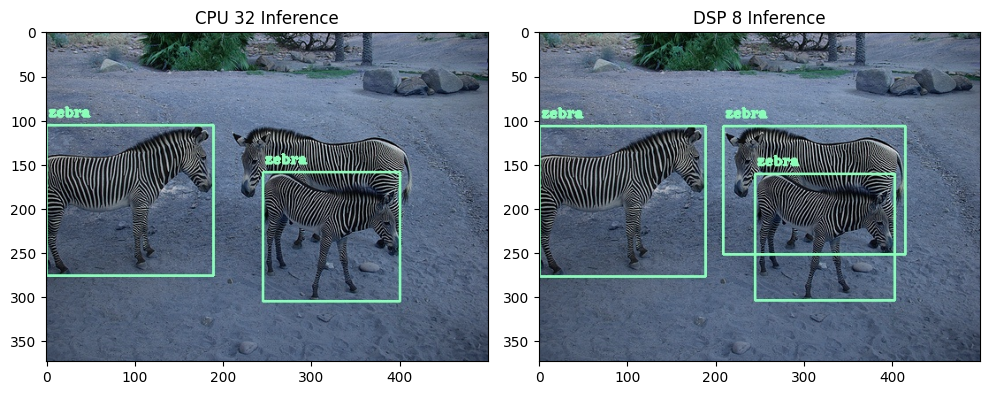

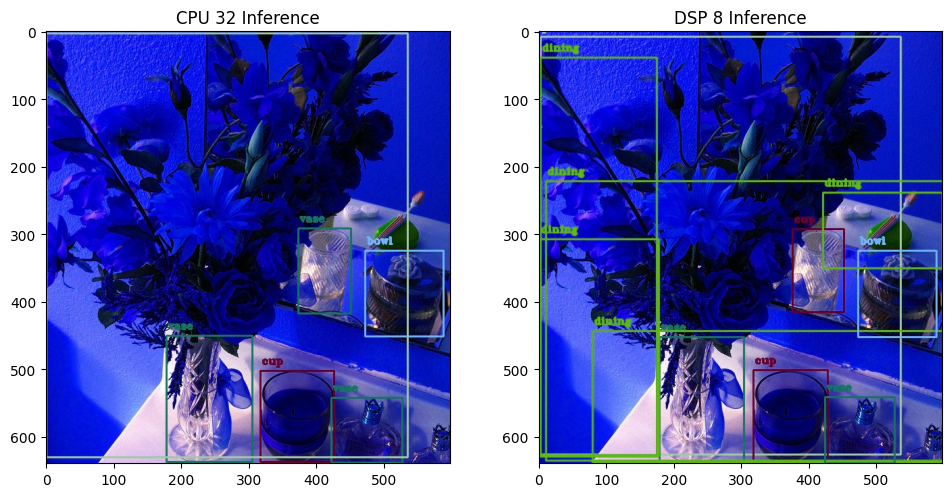

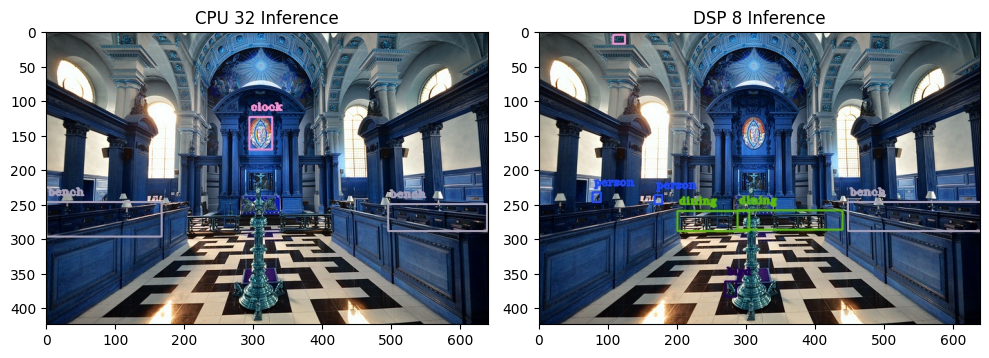

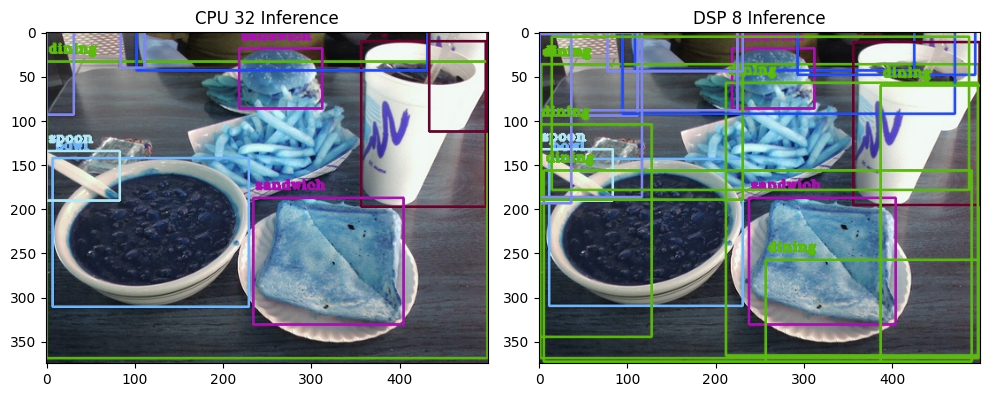

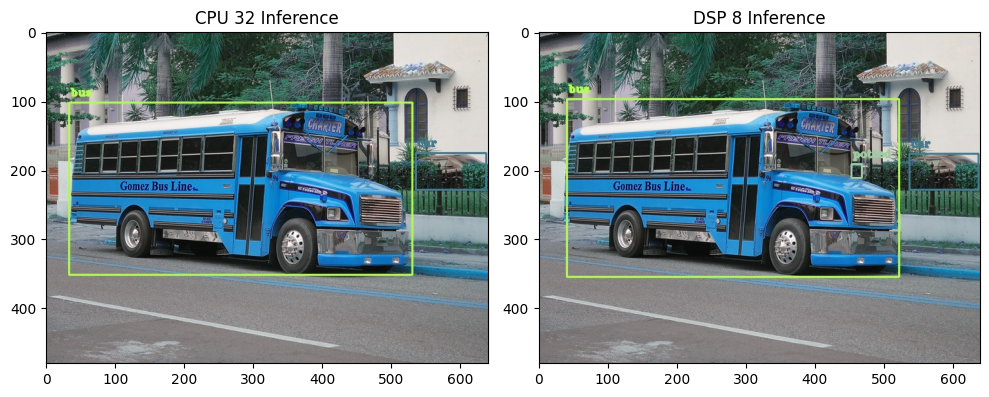

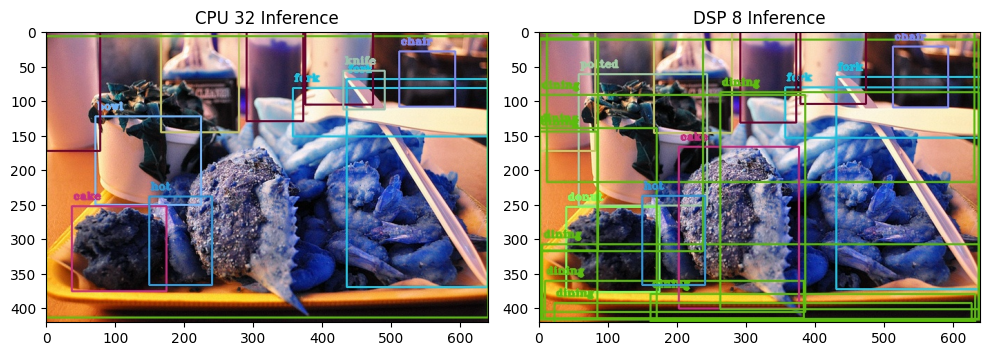

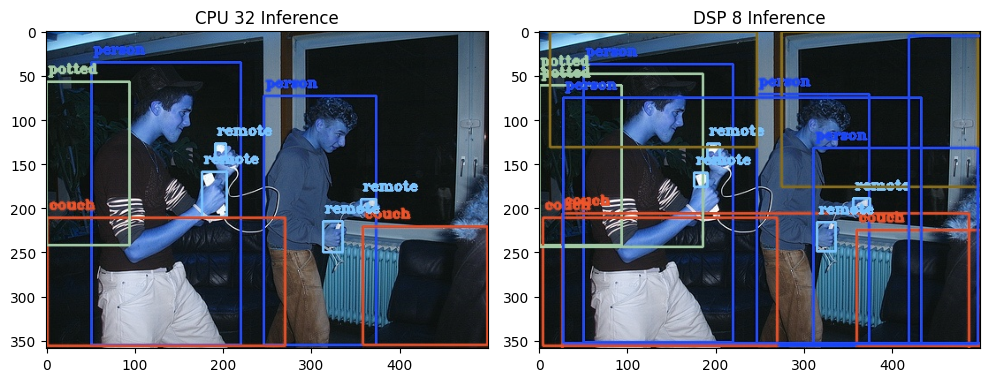

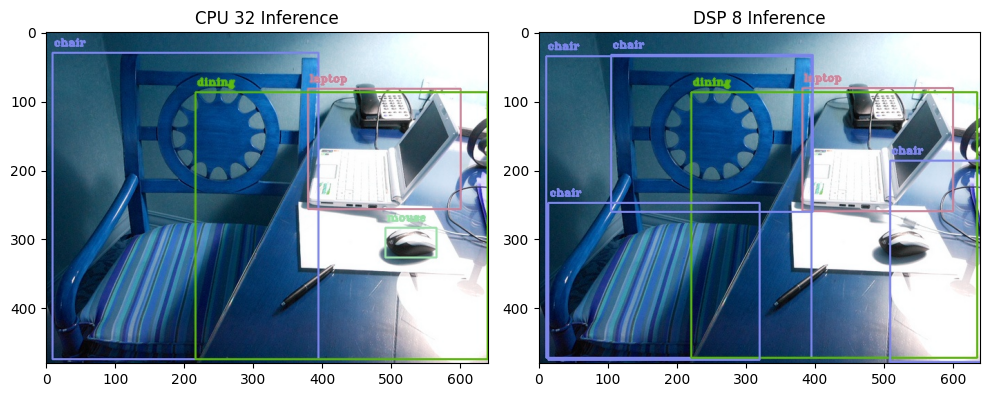

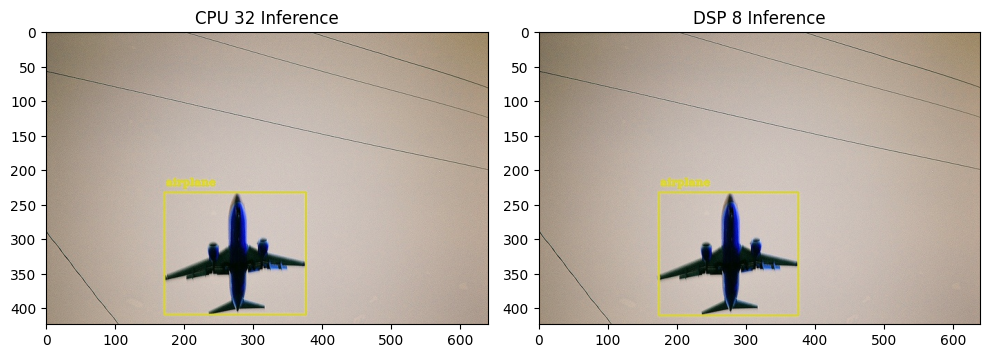

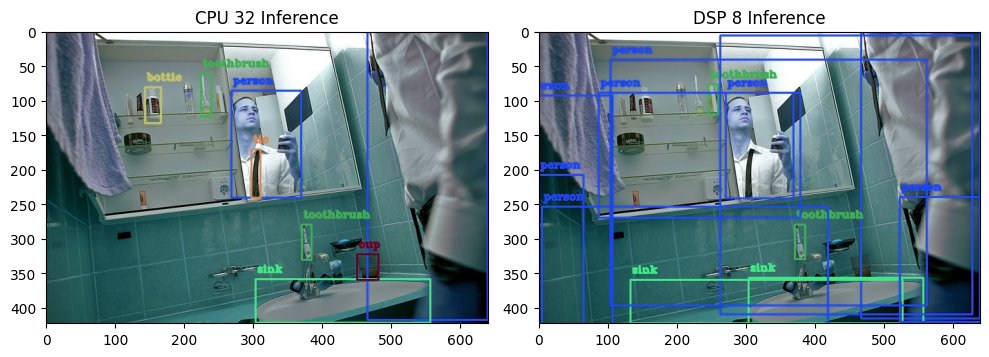

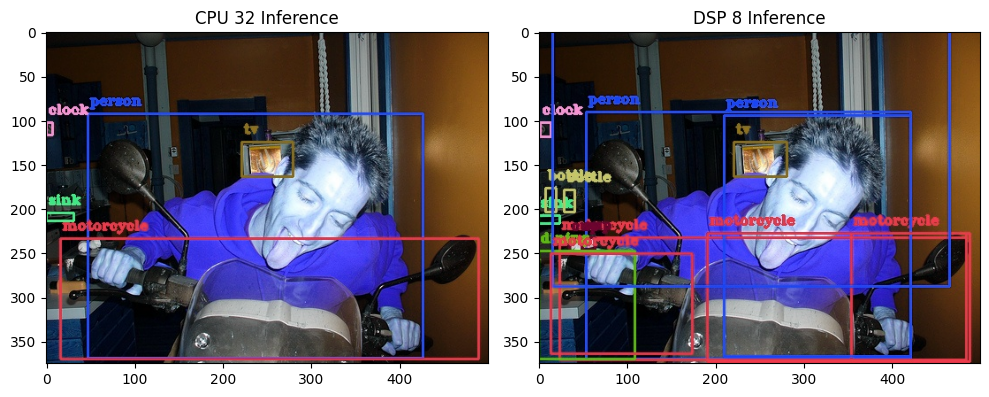

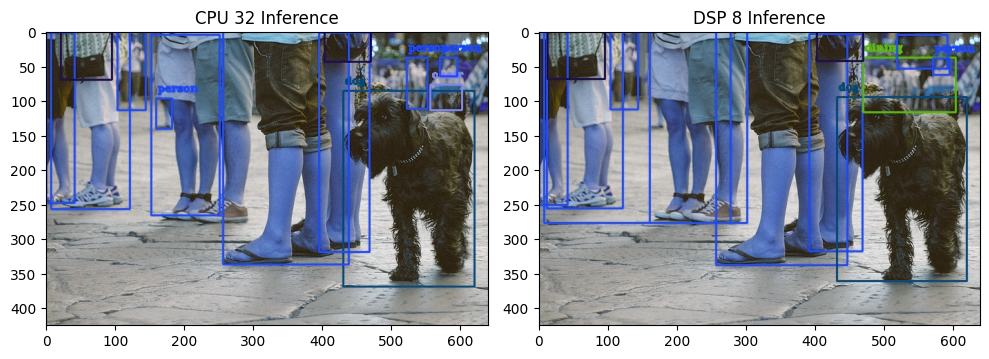

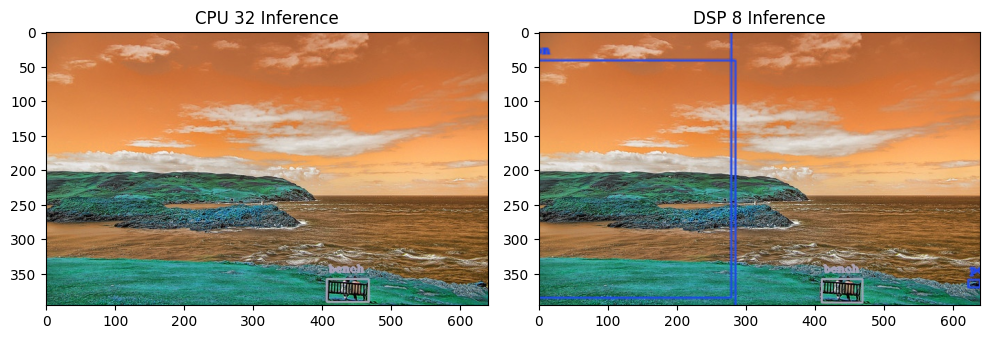

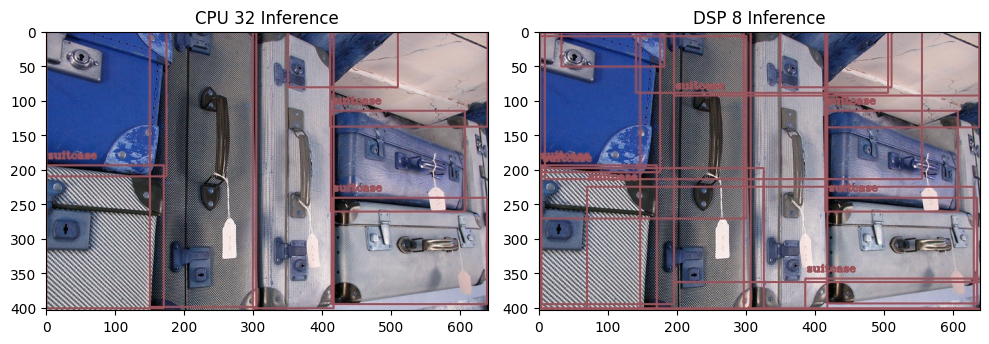

In [25]:
detection_results = ["detection_results_32b_CPU","detection_results_8b_DSP"]
for CPU_path in glob.glob(os.path.join(detection_results[0], '*')):
    CPU_img_name=CPU_path.split("/")[1].split("_")[0]
    for DSP_path in glob.glob(os.path.join(detection_results[1], '*')):
        DSP_img_name=DSP_path.split("/")[1].split("_")[0]
        
        if CPU_img_name!=DSP_img_name:continue
            
        CPU_img=cv2.imread(CPU_path)
        DSP_img=cv2.imread(DSP_path)
        fing,ax=plt.subplots(1,2,figsize=(10,5))
        ax[0].imshow(CPU_img)
        ax[0].set_title("CPU 32 Inference")

        ax[1].imshow(DSP_img)
        ax[1].set_title("DSP 8 Inference")
        plt.tight_layout()
        plt.show()
